# EAD Model

### Estimation and Interpretation

In [3]:
import pandas as pd
import numpy as np
pd.options.display.max_rows = None

In [4]:
loan_data_defaults = pd.read_csv(r'D:\Datasets\LendingClub\loan_data_defaults.csv')

C:\Users\User\AppData\Local\Temp\ipykernel_6928\1491737682.py:1: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data_defaults = pd.read_csv(r'D:\Datasets\LendingClub\loan_data_defaults.csv')


In [5]:
# credit conversion factor (ead) is proportion of original loan still outstanding at default

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
ead_inputs_train, ead_inputs_test, ead_targets_train, ead_targets_test = train_test_split(loan_data_defaults.drop(['good_bad', 'recovery_rate', 'recovery_rate_0_1', 'CCF'], axis=1), loan_data_defaults['CCF'], test_size=0.2, random_state=42)

In [10]:
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']

In [11]:
features_reference_cat = ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']

In [12]:
ead_inputs_train = ead_inputs_train[features_all]
ead_inputs_train = ead_inputs_train.drop(features_reference_cat, axis = 1)

ead_inputs_test = ead_inputs_test[features_all]
ead_inputs_test = ead_inputs_test.drop(features_reference_cat, axis = 1)

In [13]:
ead_inputs_train.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,...,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,total_acc,acc_now_delinq,total_rev_hi_lim
19698,0,0,0,1,0,0,0,0,0,0,...,26.31,0.0,2.0,0.0,0.0,17.0,0.0,34.0,0.0,13700.0
26556,0,0,1,0,0,0,0,0,0,0,...,27.21,0.0,3.0,0.0,0.0,11.0,0.0,13.0,0.0,3000.0
21857,0,0,0,1,0,0,0,0,0,0,...,20.33,0.0,1.0,0.0,0.0,7.0,0.0,38.0,0.0,14600.0
9905,0,0,1,0,0,0,1,0,0,0,...,17.31,0.0,0.0,0.0,68.0,12.0,2.0,30.0,0.0,5800.0
9205,0,0,0,0,1,0,0,0,0,0,...,24.28,0.0,0.0,72.0,0.0,13.0,0.0,35.0,0.0,15900.0


In [15]:
from sklearn import linear_model
import scipy.stats as stat
# Since the p-values are obtained through certain statistics, we need the 'stat' module from scipy.stats
# Since we are using an object oriented language such as Python, we can simply define our own 
# LinearRegression class (the same one from sklearn)
# By typing the code below we will ovewrite a part of the class with one that includes p-values
# Here's the full source code of the ORIGINAL class: https://github.com/scikit-learn/scikit-learn/blob/7b136e9/sklearn/linear_model/base.py#L362


class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """
    
    # nothing changes in __init__
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1, positive=False):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs
        self.positive = positive

    
    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        
        # Calculate SSE (sum of squared errors)
        # and SE (standard error)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])

        # compute the t-statistic for each feature
        self.t = self.coef_ / se
        # find the p-value for each feature
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

In [16]:
linreg_ead = LinearRegression()
linreg_ead.fit(ead_inputs_train, ead_targets_train)

C:\WPy64-31101\python-3.11.0.amd64\Lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


LinearRegression()

In [17]:
feature_name = ead_inputs_train.columns.values

In [18]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(linreg_ead.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', linreg_ead.intercept_]
summary_table = summary_table.sort_index()
p_values = linreg_ead.p
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,1.109750e+00,NaN
1,grade:A,-3.029920e-01,0.000000e+00
2,grade:B,-2.364187e-01,0.000000e+00
3,grade:C,-1.720165e-01,0.000000e+00
4,grade:D,-1.198412e-01,0.000000e+00
5,grade:E,-6.768169e-02,0.000000e+00
6,grade:F,-2.045856e-02,4.429336e-03
7,home_ownership:MORTGAGE,-6.341084e-03,2.641492e-03
8,home_ownership:NONE,-5.539816e-03,9.318836e-01
9,home_ownership:OTHER,-2.428389e-03,9.335180e-01


In [19]:
summary_table.to_csv(r'ead_linreg_summary_table.csv')

In [21]:
# positive coefficients indicate increase in CCF
# grade A has 30% lower CCF than grade G (reference category)

# 1 unit increase in debt to income 0.28% increase in CCF

In [24]:
# beta regression applied to stage 2 lgd
from statsmodels.othermod.betareg import BetaModel
import statsmodels.api as sm

# add a constant term to the independent variables
x = sm.add_constant(ead_inputs_train.values)

# setting targets = 1 to just less than
targets = ead_targets_train
targets = np.where(targets == 1, 1 - 1.e-6, targets)
targets = targets.reshape(-1,)

# fit the model
beta_model = BetaModel(targets, x)
beta_reg_ead = beta_model.fit(maxiter=2000, method='bfgs')

# print summary of the model
print(beta_reg_ead.summary())

# get the p-values
# p_values = beta_results.pvalues

                              BetaModel Results                               
Dep. Variable:                      y   Log-Likelihood:                 16634.
Model:                      BetaModel   AIC:                        -3.318e+04
Method:            Maximum Likelihood   BIC:                        -3.279e+04
Date:                Fri, 27 Jan 2023                                         
Time:                        20:57:45                                         
No. Observations:               34588                                         
Df Residuals:                   34542                                         
Df Model:                          45                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7098      0.116     23.407      0.000       2.483       2.937
x1            -1.3675      0.073    -18.756      0.0

In [26]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = beta_reg_ead.params[1:-1]
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', beta_reg_ead.params[0]]
summary_table = summary_table.sort_index()
p_values = beta_reg_ead.pvalues[1:-1]
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,2.709792e+00,NaN
1,grade:A,-1.367464e+00,1.713702e-78
2,grade:B,-1.089921e+00,5.180065e-74
3,grade:C,-8.237049e-01,1.677195e-56
4,grade:D,-5.685045e-01,5.566166e-35
5,grade:E,-3.054256e-01,5.713620e-13
6,grade:F,-1.075804e-01,1.137191e-02
7,home_ownership:MORTGAGE,-6.842596e-02,3.584673e-10
8,home_ownership:NONE,-5.989071e-02,8.520798e-01
9,home_ownership:OTHER,-6.062572e-02,6.903139e-01


In [27]:
summary_table.to_csv(r'ead_betareg_summary_table.csv')

### Model validation

In [29]:
y_hat_test_ead_linreg = linreg_ead.predict(ead_inputs_test)

beta_X = sm.add_constant(ead_inputs_test.values)
y_hat_test_ead_betareg = beta_reg_ead.predict(beta_X)

In [30]:
ead_targets_test_temp = ead_targets_test

In [31]:
ead_targets_test_temp = ead_targets_test_temp.reset_index(drop = True)

In [33]:
pd.concat([ead_targets_test_temp, pd.DataFrame(y_hat_test_ead_linreg)], axis = 1).corr()

,CCF,0
CCF,1.000000,0.530648
0,0.530648,1.000000


In [34]:
pd.concat([ead_targets_test_temp, pd.DataFrame(y_hat_test_ead_betareg)], axis = 1).corr()

,CCF,0
CCF,1.000000,0.517296
0,0.517296,1.000000


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\User\AppData\Local\Temp\ipykernel_6928\1358976406.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ead_targets_test - y_hat_test_ead_linreg)


<AxesSubplot: xlabel='CCF', ylabel='Density'>

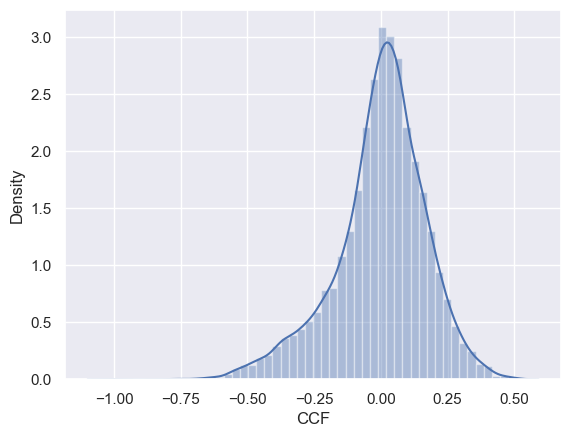

In [36]:
sns.distplot(ead_targets_test - y_hat_test_ead_linreg)

C:\Users\User\AppData\Local\Temp\ipykernel_6928\3253215705.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ead_targets_test - y_hat_test_ead_betareg)


<AxesSubplot: xlabel='CCF', ylabel='Density'>

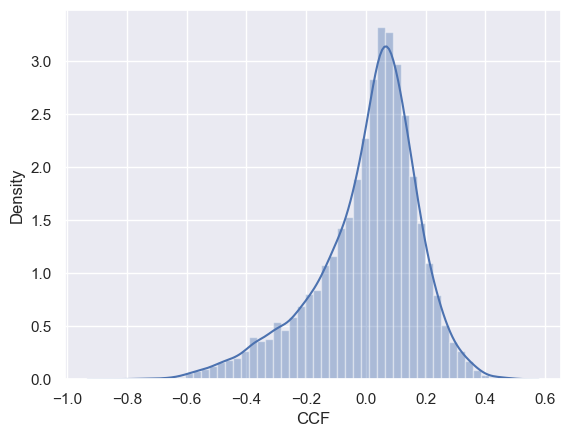

In [37]:
sns.distplot(ead_targets_test - y_hat_test_ead_betareg)

In [38]:
pd.DataFrame(y_hat_test_ead_linreg).describe()

,0
count,8648.000000
mean,0.736012
std,0.105196
min,0.384781
25%,0.661564
50%,0.731747
75%,0.810546
max,1.161524


In [39]:
pd.DataFrame(y_hat_test_ead_betareg).describe()

,0
count,8648.000000
mean,0.729579
std,0.084264
min,0.402345
25%,0.669737
50%,0.734765
75%,0.795687
max,0.992528


In [40]:
y_hat_test_ead_linreg = np.where(y_hat_test_ead_linreg < 0, 0, y_hat_test_ead_linreg)
y_hat_test_ead_linreg = np.where(y_hat_test_ead_linreg > 1, 1, y_hat_test_ead_linreg)

In [43]:
pd.DataFrame(y_hat_test_ead_linreg).describe()

,0
count,8648.000000
mean,0.735991
std,0.105129
min,0.384781
25%,0.661564
50%,0.731747
75%,0.810546
max,1.000000


In [45]:
import pickle

pickle.dump(beta_reg_ead, open('ead_betareg_model.sav', 'wb'))
pickle.dump(linreg_ead, open('ead_linreg_model.sav', 'wb'))